# Project - Classification of Human Activities

Disciplina de Tópicos de Ciência de Dados

Joana Simões, nº 2019217013

In [44]:
# imports 
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd
from sklearn import preprocessing
import scipy
import os
import seaborn as sns
sns.set()

In [45]:
import warnings
warnings.filterwarnings("ignore")

## Exercise 1.1

In [46]:
def split_train_test(X, y, percentage_test=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    return x_train, x_test, y_train, y_test

In [92]:
def split_train_test_validation(X, y, percentage_test=0.3, percentage_validation=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    percent = (len(X)*percentage_validation) / len(x_train)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percent, random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [48]:
def split_k_fold(X, y, k_folds):
    x_train = []
    x_test = []
    y_train = []
    y_test = []

    k_fold = KFold(n_splits=k_folds, random_state=42, shuffle=True)

    for train_index, test_index in k_fold.split(X):
        x_train.append(X.loc[train_index])
        y_train.append(y[train_index])
        x_test.append(X.loc[test_index])
        y_test.append(y[test_index])

    return x_train, x_test, y_train, y_test

## Exercise 1.2

In [194]:
def plot_percentages(classes_groups, labels=None, title=''):
    plt.figure()
    plt.pie(classes_groups, labels=labels, autopct='%.0f%%')
    plt.title(title)
    plt.show()

In [49]:
def display_confusion_matrix(cm, labels=None, title=''):
    plt.figure()
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    display.plot()
    plt.title(title)
    plt.show()

In [50]:
def calculate_confusion_matrix(y, y_pred, labels=None, display=True, title=''):
    cm = confusion_matrix(y, y_pred, labels=labels)
    if display:
        display_confusion_matrix(cm, labels, title=title)
    return cm

In [51]:
def calculate_recall(y, y_pred, metric=None):
    score = recall_score(y, y_pred, average=metric)
    return score

In [52]:
def calculate_precision(y, y_pred, metric=None):
    return precision_score(y, y_pred, average=metric)

In [53]:
def calculate_f1(y, y_pred, metric=None):
    return f1_score(y, y_pred, average=metric)

In [54]:
def plot_measures(recalls, precisions, f1_scores, title=''):
    plt.figure()
    x = np.arange(len(recalls))+1
    plt.plot(x, recalls, label='Recall')
    plt.plot(x, precisions, label='Precision')
    plt.plot(x, f1_scores, label='F1 score')
    plt.xlabel('K values')
    plt.ylabel('Result')
    plt.title(title)
    plt.legend()
    plt.show()

## Exercise 2 -Test TTS e CV with KNN

Nos testes elaborados abaixo, foi utilizada a métrica do F1-score para comparar a performance de diferentes modelos (ou parâmetros deste).

In [55]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [198]:
def load_dataset():
    iris_dataset = datasets.load_iris(as_frame=True)
    X = iris_dataset.data
    y = iris_dataset.target
    target_names = iris_dataset.target_names
    return X, y, target_names

In [199]:
X, y, target_names = load_dataset()

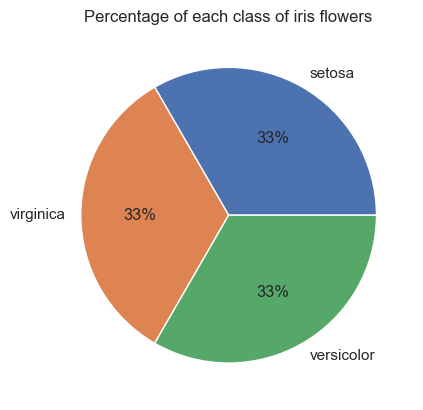

In [200]:
plot_percentages(y.value_counts().sort_index(), labels=['setosa', 'virginica', 'versicolor'], title='Percentage of each class of iris flowers')

### Train-only : k=1

In [59]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X,  y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F1 score: 1.0


<Figure size 640x480 with 0 Axes>

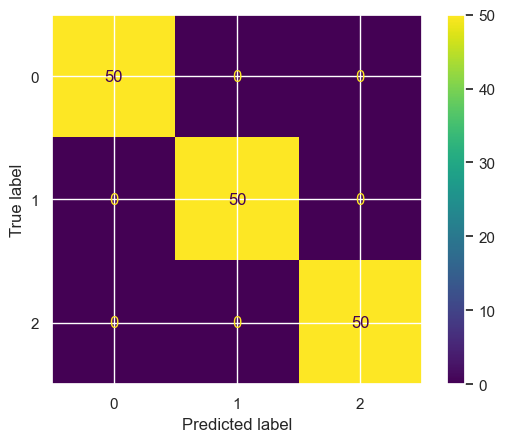

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [60]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:',calculate_precision(y, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred)

Ao utilizar os mesmos dados para treino e teste, e com um K=1 no *K-nearest neighbors*, ou seja, utilizando o valor do próprio ponto, como era de esperar, o resultado é que o modelo consegue prever todas as classes na totalidade. 

### Train-test 70-30 - k=1

In [201]:
x_train, x_test, y_train, y_test = split_train_test(X, y, 0.3)

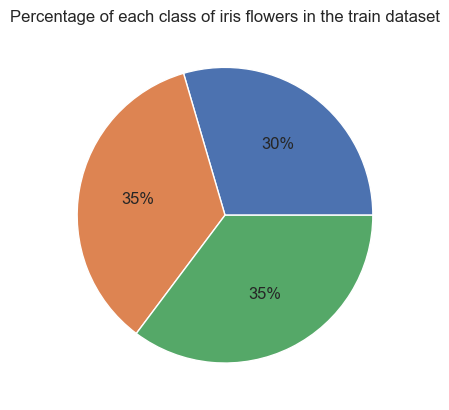

In [202]:
plot_percentages(list(y_train.value_counts().sort_index()), title='Percentage of each class of iris flowers in the train dataset')

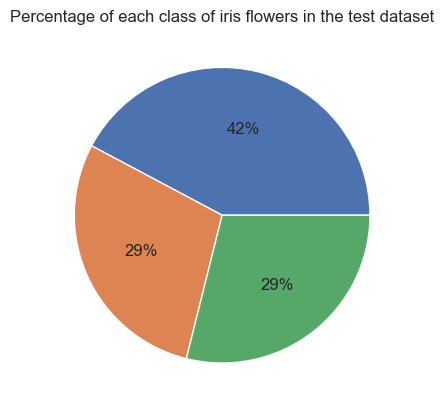

In [203]:
plot_percentages(list(y_test.value_counts().sort_index()), title='Percentage of each class of iris flowers in the test dataset')


Recall: 1.0
Precision: 1.0
F1 score: 1.0


<Figure size 640x480 with 0 Axes>

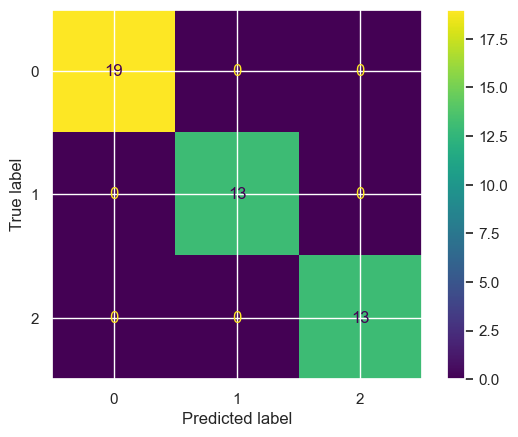

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [204]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:',calculate_precision(y_test, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred)

Utilizando 70% do dataset para treino e 30% do dataset para teste, e havendo uma distribuição mais ou menos uniforme de cada classe nos dois datasets, é possível observar que o modelo K-nearest neighbors com um k=1, ou seja, utilizando apenas o ponto mais próximo na predição, obtem bons resultados nos testes. Isto deve-se ao facto de as classes estarem distribuidas de tal forma que é possível separá-las e, assim, prever os pontos com exatidão. 

### 10CV - k=1

In [105]:
def cross_validation_test(iters, X, y, k_folds=10):
    iters_recalls = []
    iters_precisions = []
    iters_f1_scores = []
    x_train, x_test, y_train, y_test = split_k_fold(X, y, k_folds)
    for iter in range(iters):
        recalls = []
        precisions = []
        f1_scores = []
        for i in range(len(x_train)):
            model = KNeighborsClassifier(n_neighbors=iter+1)
            model.fit(x_train[i], y_train[i])
            y_pred = model.predict(x_test[i])

            recalls.append(calculate_recall(y_test[i], y_pred))
            precisions.append(calculate_precision(y_test[i], y_pred))
            f1_scores.append(calculate_f1(y_test[i], y_pred))
        r_mean = np.mean(recalls)
        p_mean = np.mean(precisions)
        f_mean = np.mean(f1_scores)
        print(f'********* Averages - k={iter+1} **********')
        print('Recall:', r_mean)
        print('Precision:',p_mean)
        print('F1 Score:', f_mean)

        iters_recalls.append(r_mean)
        iters_precisions.append(p_mean)
        iters_f1_scores.append(f_mean)
    if iters > 1:
        plot_measures(iters_recalls, iters_precisions, iters_f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(iters_recalls)+1)
        print('Precision: ', np.argmax(iters_precisions)+1)
        print('F1-Score: ', np.argmax(iters_f1_scores)+1)
        return np.argmax(f1_scores)+1
    return None


In [107]:
bests = cross_validation_test(1, X, y)

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589


In [108]:
def avg_confusion_matrix(confusion_matrices, display=True):
    avg_cm = confusion_matrices[0]
    for i in range(1, len(confusion_matrices)):
        avg_cm += confusion_matrices[i]
    avg_cm = avg_cm / len(confusion_matrices)
    if display:
        display_confusion_matrix(avg_cm, None)
    return avg_cm

### Train only - multiple k values

In [205]:
def train_only_test(iters, X, y):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(15):
        model = KNeighborsClassifier(n_neighbors = i+1)
        model.fit(X, y)
        y_pred = model.predict(X)
        recall = calculate_recall(y, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)
    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
********* Averages - k=2 **********
Recall: 0.98
Precision: 0.9811320754716981
F1 Score: 0.9799819837854068
********* Averages - k=3 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=4 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=5 **********
Recall: 0.9666666666666667
Precision: 0.9667867146858743
F1 Score: 0.9666633329999667
********* Averages - k=6 **********
Recall: 0.9733333333333334
Precision: 0.9733333333333334
F1 Score: 0.9733333333333334
********* Averages - k=7 **********
Recall: 0.9733333333333334
Precision: 0.9738247863247864
F1 Score: 0.9733226623982927
********* Averages - k=8 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=9 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=10 **********
Recall: 0.98
Precision: 0.980125383486

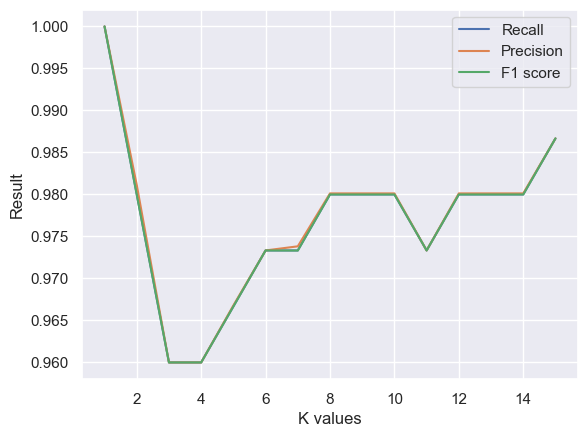

Best k
Recall:  1
Precision:  1
F1-Score:  1


In [206]:
best_k_train_only = train_only_test(15, X, y)

In [207]:
model = KNeighborsClassifier(n_neighbors=best_k_train_only)
model.fit(X, y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

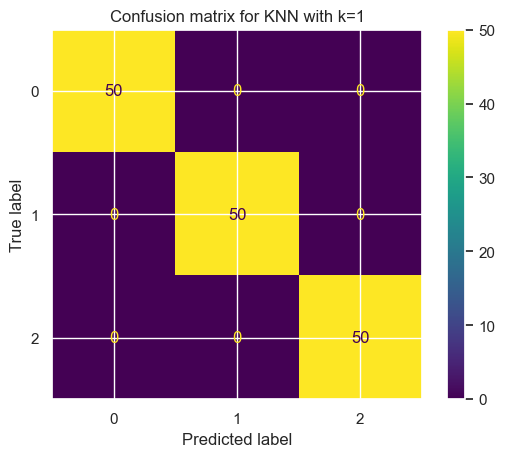

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [208]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:', calculate_precision(y, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred, title=f'Confusion matrix for KNN with k={best_k_train_only}')

Utilizando os mesmos dados para treino e teste mostra que o melhor k do K-nearest neighbors continua a ser o K=1, uma vez que como são os mesmos dados, o modelo utiliza o proprio ponto previamente guardado para prever, ou seja, acerta 100% das vezes. 

### TVT 40-30-30 - multiple k values

In [209]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [210]:
def tvt_test(iters, x_train, x_val, y_train, y_val):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(iters):
        model = KNeighborsClassifier(n_neighbors=i+1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        recall = calculate_recall(y_val, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y_val, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y_val, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)

    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 0.9111111111111111
Precision: 0.9111111111111111
F1 Score: 0.9111111111111111
********* Averages - k=2 **********
Recall: 0.9111111111111111
Precision: 0.9111111111111111
F1 Score: 0.9111111111111111
********* Averages - k=3 **********
Recall: 0.9555555555555556
Precision: 0.9611111111111111
F1 Score: 0.955648148148148
********* Averages - k=4 **********
Recall: 0.9333333333333333
Precision: 0.9349074074074074
F1 Score: 0.9334726576105885
********* Averages - k=5 **********
Recall: 0.9333333333333333
Precision: 0.9450980392156864
F1 Score: 0.9333333333333333
********* Averages - k=6 **********
Recall: 0.9333333333333333
Precision: 0.9450980392156864
F1 Score: 0.9333333333333333
********* Averages - k=7 **********
Recall: 0.9333333333333333
Precision: 0.9450980392156864
F1 Score: 0.9333333333333333
********* Averages - k=8 **********
Recall: 0.9555555555555556
Precision: 0.9611111111111111
F1 Score: 0.955648148148148
********* Averages - k=9 *

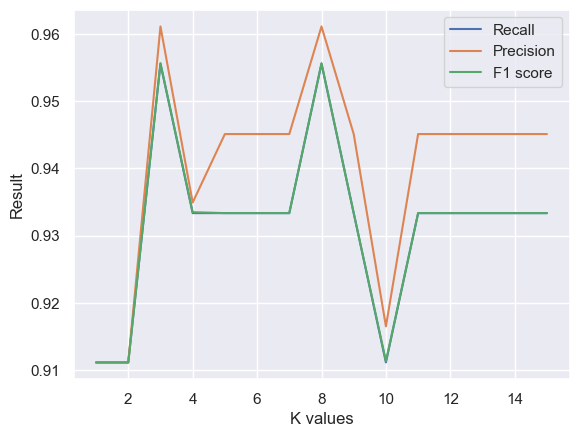

Best k
Recall:  3
Precision:  3
F1-Score:  3


In [211]:
best_k = tvt_test(15, x_train, x_val, y_train, y_val)

Pode-se observar que o K=3 e K=8 têm o mesmo resultado nas métricas, e ambos com as melhores performances. Assim, foi escolhido o melhor K como sendo o k=3 porque gera um modelo mais simples. 

#### retrain the model using the best k

In [212]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [213]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total, y_train_total)
y_pred = model.predict(x_test)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

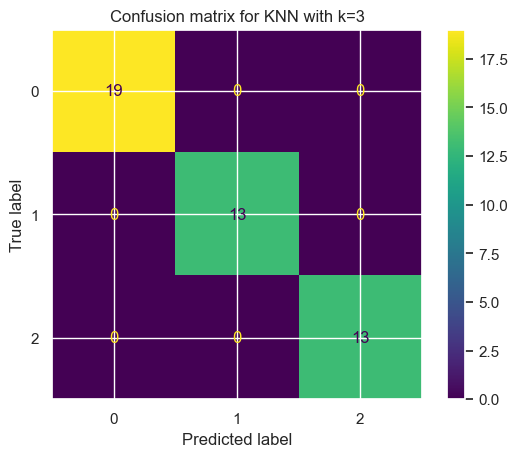

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [214]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k}')

Neste teste, foi utilizado 40% do dataset para teste e 30% do dataset para validação. Com estes datasets, foi calculado o melhor k para o modelo, sendo este o k=3 como já referido anteriormente. Após calcular o melhor k, juntaram-se os dois datasets e o modelo foi novamente treinado com o k ideal. Por último,foi utilizado 30% do dataset inicial previamente guardado e foi testada a precisão do modelo. Como se pode observar, o modelo consegui prever com exatidão a totalidade dos dados de teste.

### 10 CV - multiple k values

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589
********* Averages - k=2 **********
Recall: 0.9541269841269842
Precision: 0.9548412698412698
F1 Score: 0.9514263514263513
********* Averages - k=3 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=4 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=5 **********
Recall: 0.9730158730158731
Precision: 0.9785714285714285
F1 Score: 0.9712065712065712
********* Averages - k=6 **********
Recall: 0.9596825396825397
Precision: 0.9671428571428572
F1 Score: 0.9575313575313575
********* Averages - k=7 **********
Recall: 0.9552380952380953
Precision: 0.9585714285714285
F1 Score: 0.9487991637991638
********* Averages - k=8 **********
Recall: 0.9735714285714286
Precision: 0.979047619047619
F1 Score: 0.973870573870574
********* Averages - k=9 ***

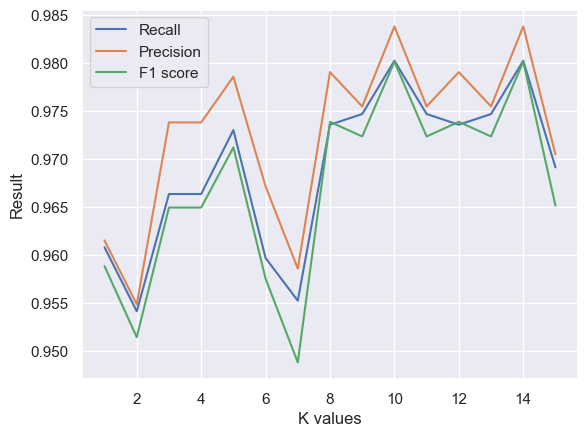

Best k
Recall:  10
Precision:  10
F1-Score:  10


In [215]:
best_k_cv = cross_validation_test(15, X, y, k_folds=10)

Como se pode observar o k=10 é o que obtêm os melhores resultados nas médias dos resultados da cross-validation.

KNN - com um K pequeno, o modelo fica mais sensivel a ruido e a overfitting
Quando usamos um K grande, fica pouco sensivel

Usar k impar sempre que temos um numero classes par

## ReliefF - Ex.2.2

In [78]:
from skfeature.function.similarity_based import fisher_score, reliefF

In [146]:
def plot_elbow(f1_scores, k_model, metric, title=None):
    f1_scores = [0] + f1_scores
    plt.figure(figsize=(15, 7))
    plt.plot(np.arange(len(f1_scores)), f1_scores, '*-')
    plt.ylim(0, 1.05)
    plt.xlim(0, len(f1_scores) + 0.2)
    if title is not None:
        plt.title(f'Plot with the features used, using the model KNN with k={k_model}, features ranked using {metric}')
    else:
        plt.title(title)
    plt.ylabel(f'F1 score')
    plt.xlabel(f'Nº features used')
    plt.show()

In [145]:
def plot_elbows(scores, k_values):
    plt.figure()
    x = np.arange(0, len(scores[0])+1)
    x = x.astype(int)
    for k in range(len(k_values)):
        plt.plot(x, [0] + scores[k], '*-', label=k_values[k])
    plt.legend()
    plt.xlabel('Number features used')
    plt.ylim(0, 1.05)
    plt.xlim(0, len(scores[0])+0.2)
    plt.ylabel('F1-Score')
    plt.show()

In [81]:
def order_features(x_train, y_train, metric='reliefF'):
    if metric == 'reliefF':
        # ReliefF
        print('reliefF')
        score = reliefF.reliefF(x_train.to_numpy(), y_train.to_numpy())
    else:
        # fisher
        print('fisher')
        score = fisher_score.fisher_score(x_train.to_numpy(), y_train.to_numpy())
    
    features_ranked = (-score).argsort()
    features = x_train.columns

    print(f'Features ranked by {metric}:')
    print(list(features[features_ranked]))
    print(f'Scores:')
    print(score)

    return list(features[features_ranked])

In [147]:
def best_model_feature_and_k(x_train, x_val, y_train, y_val, features, function='ReliefF', plot=False, k_max=15, step=1):
    df = pd.DataFrame()

    max_score = 0
    best_k = 0
    best_n_features = 0

    features_scores = []
    k_values = []

    for k in range(1, k_max+1, step):
        f1_scores = []
        for n_features in range(1, len(features)+1):
            features_to_use = features[:n_features]
            model = KNeighborsClassifier(n_neighbors=k+1)
            model.fit(x_train[features_to_use], y_train)
            y_pred = model.predict(x_val[features_to_use])
            f1 = calculate_f1(y_val, y_pred,  'weighted')
            if f1 > max_score:
                max_score = f1
                best_k = k+1
                best_n_features = n_features
            f1_scores.append(f1)
        features_scores.append(f1_scores)
        k_values.append(k)
        df[f'K{k+1}'] = pd.Series(np.array(f1_scores))
        if plot:
            plot_elbow(f1_scores, k+1, function)

    plot_elbows(features_scores, k_values)

    df = df.set_index(np.arange(1, len(features)+1))
    print('Max f1-score: ', max_score)
    print('Model used: ', best_k)
    print('Best number features:', best_n_features)
    return df, best_k, best_n_features

In [121]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [122]:
relieff_features = order_features(x_train, y_train)

reliefF
Features ranked by reliefF:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[178.42897187 115.47781074 563.99357289 238.41156522]


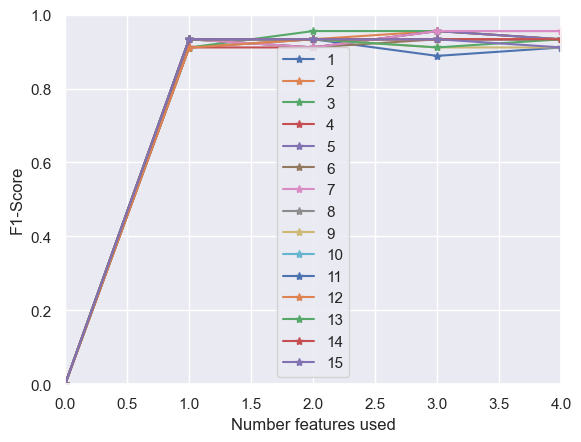

Max f1-score:  0.955648148148148
Model used:  3
Best number features: 3


In [123]:
results, best_k, best_n_features_relief = best_model_feature_and_k(x_train, x_val, y_train, y_val, relieff_features, plot=False)

In [124]:
results

,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15,K16
1,0.911111,0.911296,0.911111,0.911296,0.933473,0.933473,0.933473,0.933333,0.933333,0.933333,0.933333,0.910741,0.933473,0.933333,0.933473
2,0.933473,0.933473,0.955556,0.911296,0.911296,0.911296,0.911296,0.933333,0.933333,0.933333,0.933473,0.933473,0.933473,0.933333,0.933333
3,0.888419,0.955648,0.955648,0.955648,0.955648,0.933333,0.955648,0.933333,0.911296,0.933333,0.933473,0.933333,0.911296,0.933333,0.933473
4,0.911111,0.955648,0.933473,0.933333,0.933333,0.933333,0.955648,0.933333,0.911296,0.933333,0.933333,0.933333,0.933333,0.933333,0.911296


#### retrain best model

In [125]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [126]:
features_to_use = relieff_features[:best_n_features_relief]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

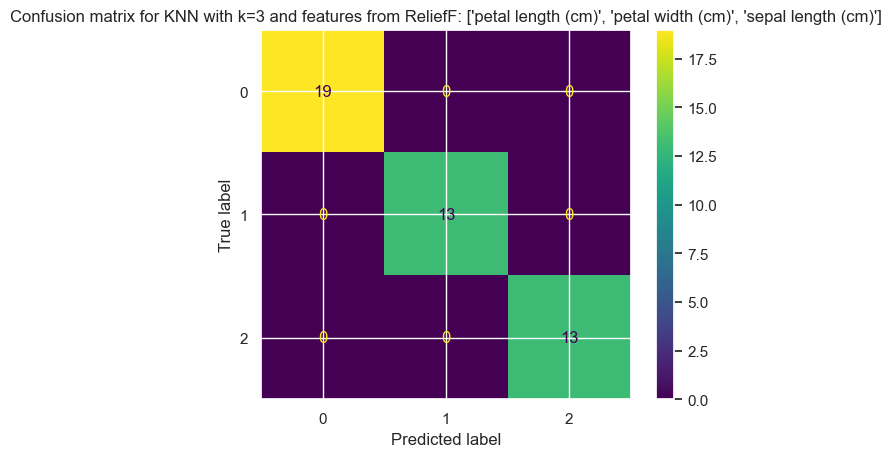

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [127]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from ReliefF: {features_to_use}')

Ao re-treinar o modelo com o número ideal de features e com o k (número de vizinhos ideal), é possivel observar pela matriiz de confu~soa que o modelo consegue classificar com precisão máxima a amostra que foi guardada para treino.

## Fisher Score - Ex.2.3

In [128]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [129]:
fisher_features = order_features(x_train, y_train, 'fisher')

fisher
Features ranked by fisher:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[ 1.35226876  0.92830557 16.80956604 10.94547513]


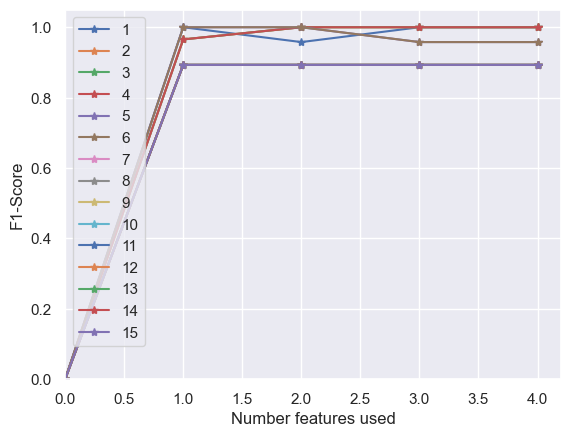

Max f1-score:  1.0
Model used:  2
Best number features: 1


In [148]:
results, best_k, best_n_features_fisher = best_model_feature_and_k(x_train, x_val, y_train, y_val, fisher_features, plot=False)

In [149]:
results

,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15,K16
1,1.000000,0.965432,0.965432,0.965432,1.000000,1.000000,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004
2,0.957879,1.000000,1.000000,1.000000,1.000000,1.000000,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004
3,1.000000,1.000000,1.000000,1.000000,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004
4,1.000000,1.000000,1.000000,1.000000,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004,0.893004


#### retrain best model

In [133]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [134]:
features_to_use = fisher_features[:best_n_features_fisher]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

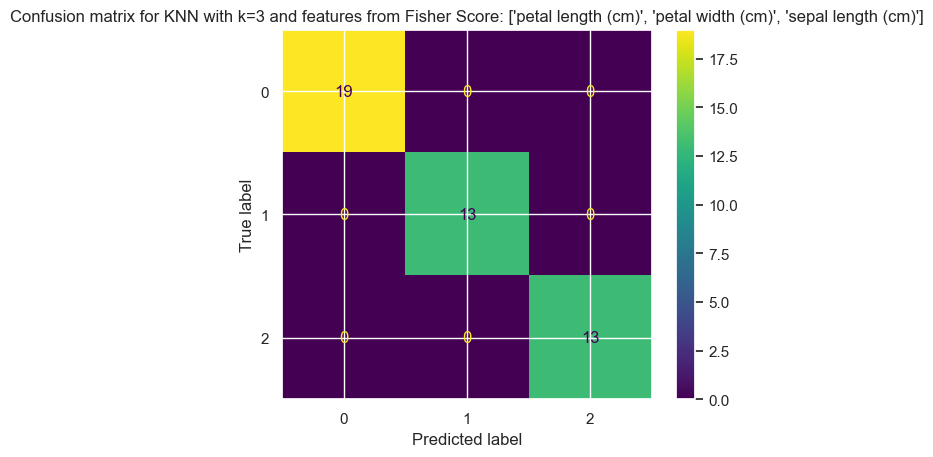

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [135]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from Fisher Score: {features_to_use}')

Como a ordem de importância das features utilizando o Fisher Score e RelieF foram iguais, os resultados de melhor nº de features a utilizar e melhor K são iguais também.

## Ex 2.4 - restrict classes

In [161]:
indexes_setosa = pd.Series(y[y==0].index)
indexes_versicolor = pd.Series(y[y == 1].index).sample(30)
indexes_virginica = pd.Series(y[y==2].index).sample(10)

In [162]:
new_X = pd.concat([X.loc[indexes_setosa], X.loc[indexes_versicolor], X.loc[indexes_virginica]], ignore_index=True)
new_y = pd.concat([y[indexes_setosa], y[indexes_versicolor], y[indexes_virginica]], ignore_index=True)

In [160]:
classes_groups = list(new_y.value_counts().sort_index())

In [164]:
labels = ['setosa', 'virsicolor', 'virginica']

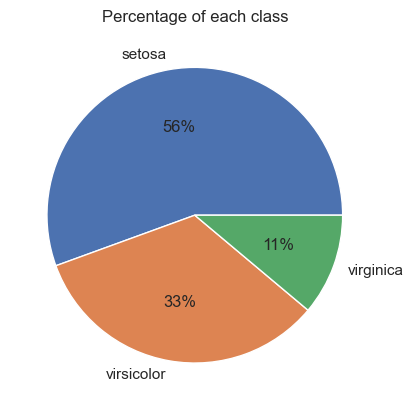

In [168]:
plt.figure()
plt.pie(classes_groups, labels=labels, autopct='%.0f%%')
plt.title('Percentage of each class')
plt.show()

In [152]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(new_X, new_y)

In [153]:
fisher_features = order_features(x_train, y_train, 'fisher')

fisher
Features ranked by fisher:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[ 1.77314083  0.47080469 24.81425206 23.52596164]


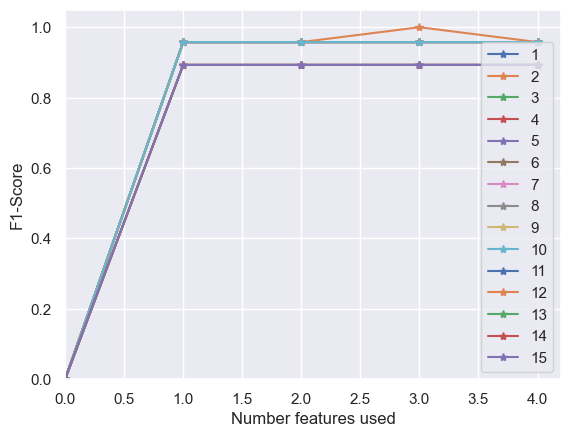

Max f1-score:  1.0
Model used:  3
Best number features: 3


In [154]:
results, best_k, best_n_features = best_model_feature_and_k(x_train, x_val, y_train, y_val, fisher_features, plot=False)

In [155]:
results

,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15,K16
1,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004
2,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004
3,0.957879,1.000000,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004
4,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.957879,0.893004,0.893004,0.893004,0.893004,0.893004


#### retrain best model

In [156]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [157]:
features_to_use = fisher_features[:best_n_features]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 0.9629629629629629
Precision: 0.9753086419753086
F-Score: 0.9655773420479302


<Figure size 640x480 with 0 Axes>

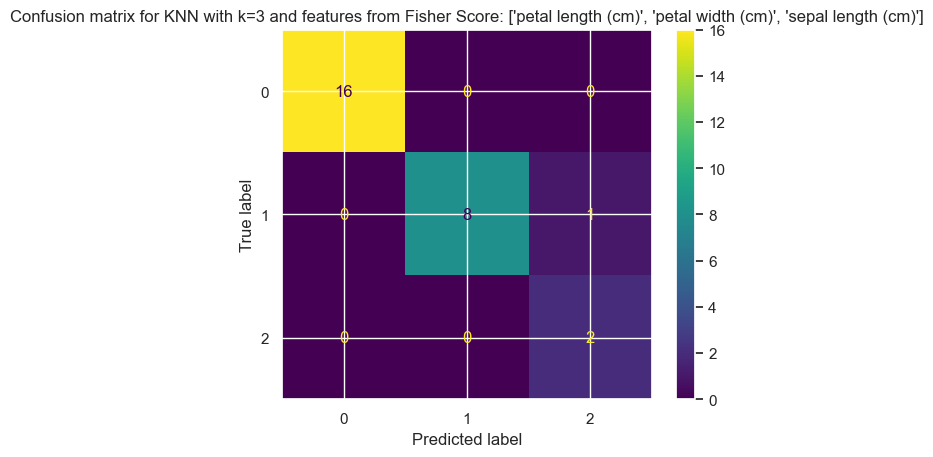

array([[16,  0,  0],
       [ 0,  8,  1],
       [ 0,  0,  2]], dtype=int64)

In [158]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from Fisher Score: {features_to_use}')

Verifica-se que ao pertubar as percentagens de cada tipo de flor no dataset, ou seja, tendo um dataset desenbalaceado, a performance do modelo diminui.

## Ex 3 - test models with human activities dataset

In [187]:
activities_labels = {
    1 : 'STAND',
    2 : 'SIT',
    3 : 'SIT&TALK',
    4 : 'WALK',
    5 : 'WALK&TALK',
    6 : 'CLIMB_STAIRS',
    7 : 'CLIMB_STAIRS&TALK',
    8 : 'STAND_TO_SIT',
    9 : 'SIT_TO_STAND',
    10: 'STAND_TO_SIT&TALK',
    11: 'SIT&TALK_TO_STAND',
    12: 'STAND_TO_WALK', 
    13: 'WALK_TO_STAND', 
    14: 'STAND_TO_CLIMB_STAIRS',
    15: 'CLIMB_STAIRS_TO_WALK',
    16: 'CLIMB_STAIRS&TALK_TO_WALK&TALK', 
}

In [175]:
features_path = os.path.join('results', 'extracted_features.csv')

In [176]:
X = pd.read_csv(features_path)
y = X.pop('activity')

In [177]:
data_activities = pd.DataFrame()
data_activities['activity'] = list(activities_labels.values())
data_activities['count'] = y.value_counts().sort_index()

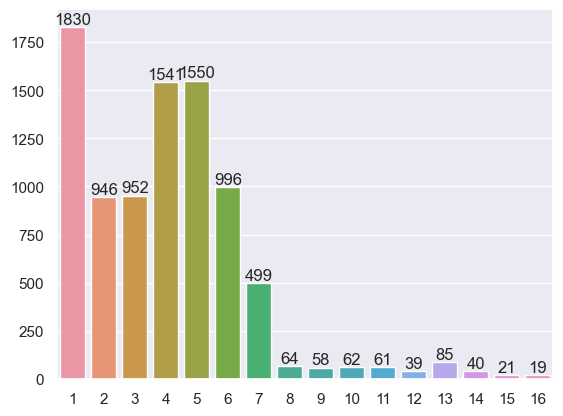

In [178]:
plt.figure()
ax = sns.barplot(x=list(activities_labels.keys()), y=list(y.value_counts().sort_index()))
for i in ax.containers:
    ax.bar_label(i,)

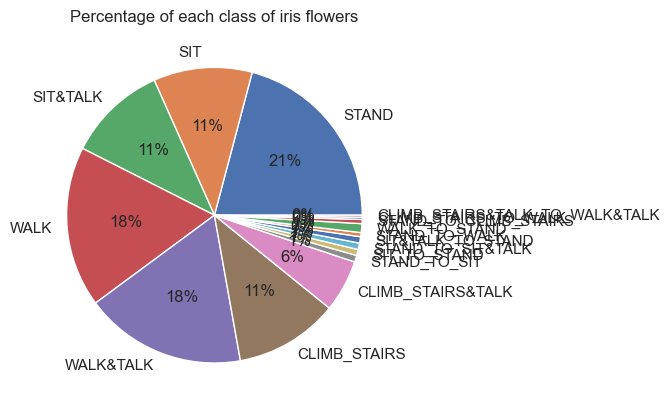

In [186]:
plot_percentages(list(y.value_counts().sort_index()), labels=list(activities_labels.values()))

Como se pode observar, não existe uma distribuição uniforme das atividades, algumas atividades existem em mais abundância que outras, podendo prever já há partida que o modelo terá dificildade em classificar as atividades.

In [188]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [189]:
%%time
relieff_features = order_features(x_train, y_train)

reliefF
Features ranked by reliefF:
['are', 'aae', 'accelerometer_x_energy', 'accelerometer_y_energy', 'accelerometer_z_energy', 'gyroscope_x_energy', 'gyroscope_y_energy', 'gyroscope_z_energy', 'magnetometer_x_energy', 'magnetometer_y_energy', 'magnetometer_z_energy', 'gyroscope_x_variance', 'gyroscope_y_variance', 'gyroscope_z_variance', 'avg', 'gyroscope_z_df', 'gyroscope_x_df', 'gyroscope_x_interquantile', 'gyroscope_y_interquantile', 'accelerometer_x_df', 'gyroscope_y_rms', 'gyroscope_y_df', 'gyroscope_x_std', 'gyroscope_x_rms', 'gyroscope_y_std', 'accelerometer_z_df', 'gyroscope_y_mean', 'gyroscope_y_median', 'accelerometer_z_mean_crossing_rate', 'magnetometer_z_mean_crossing_rate', 'accelerometer_y_mean_crossing_rate', 'magnetometer_x_mean_crossing_rate', 'gyroscope_z_interquantile', 'gyroscope_z_mean_crossing_rate', 'gyroscope_x_mean_crossing_rate', 'gyroscope_y_mean_crossing_rate', 'accelerometer_x_mean_crossing_rate', 'magnetometer_y_mean_crossing_rate', 'gyroscope_z_rms', 'g

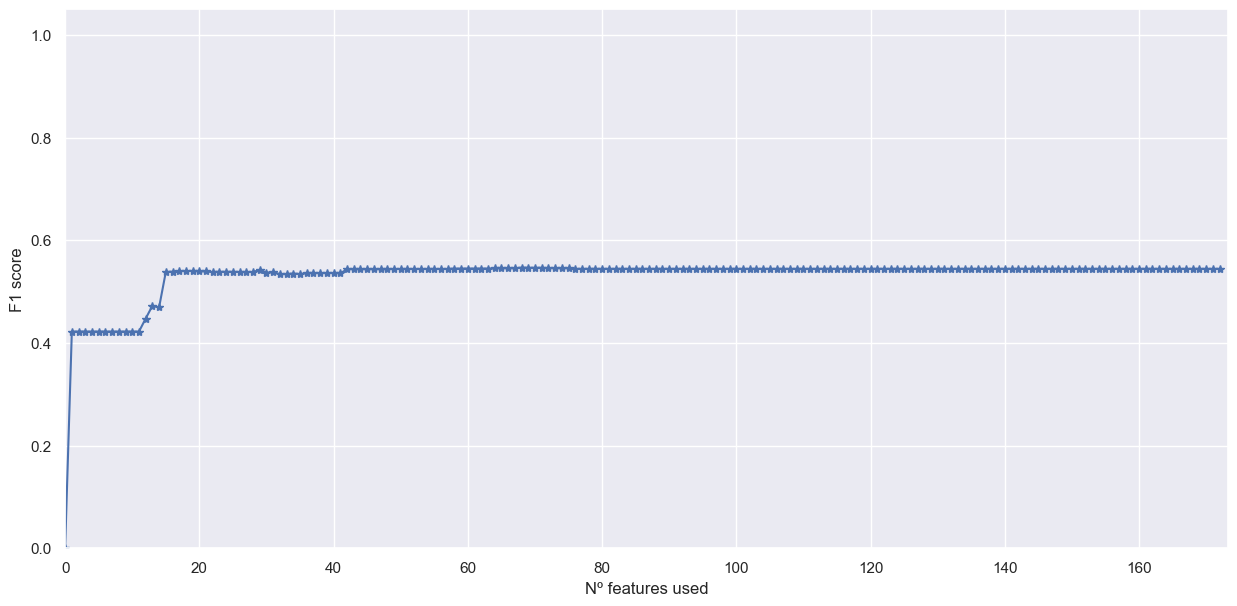

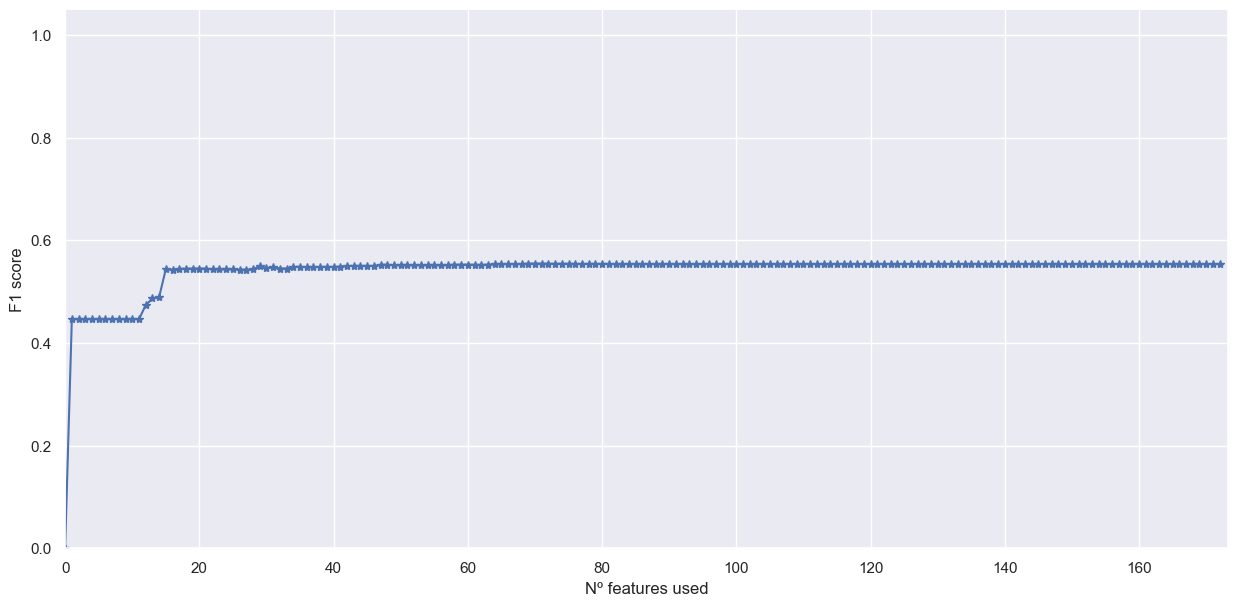

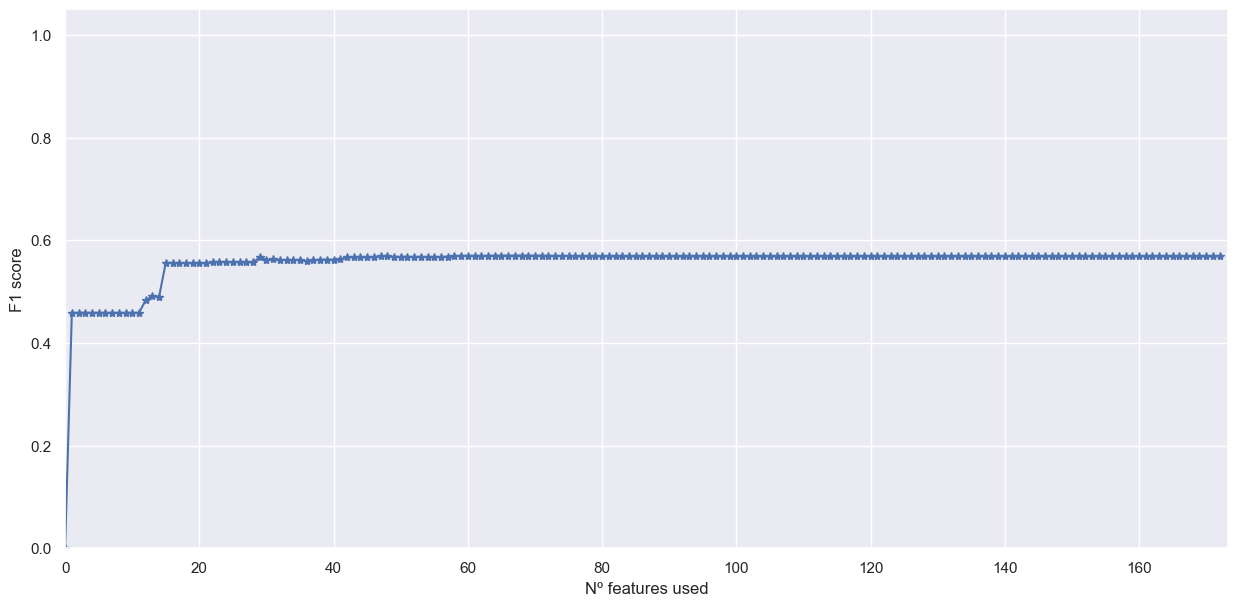

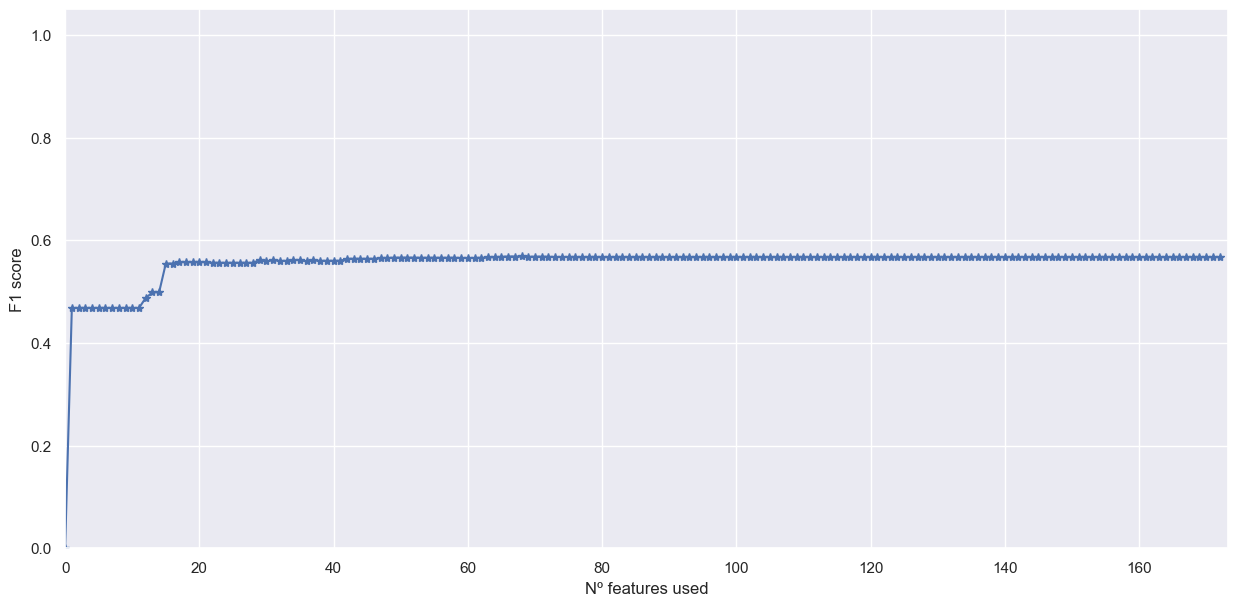

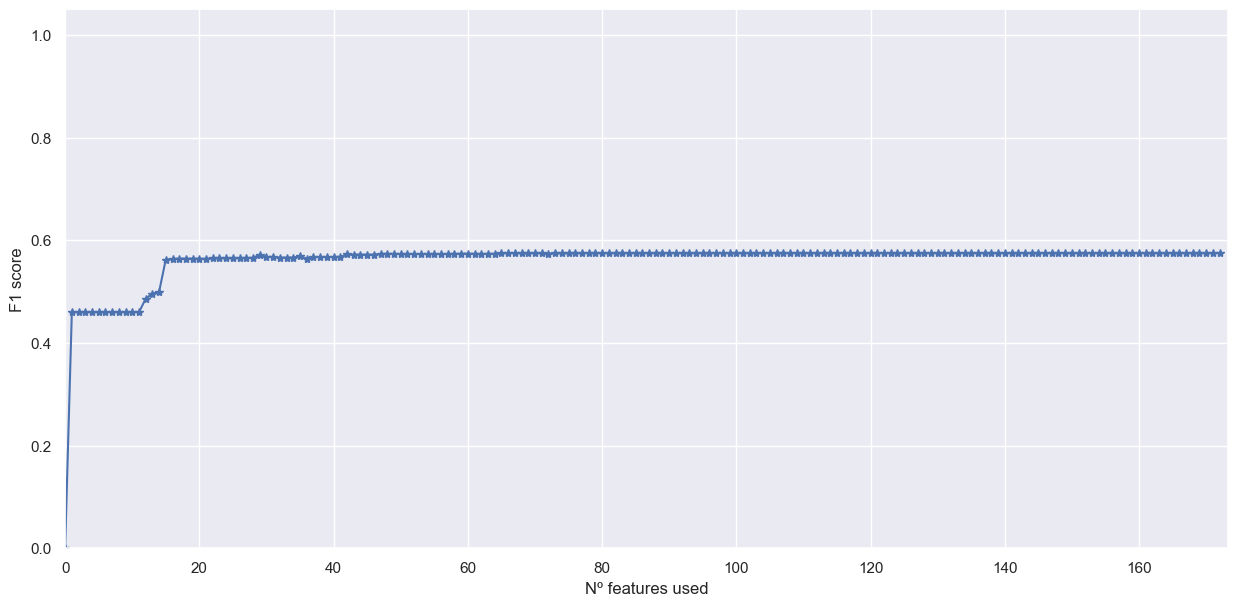

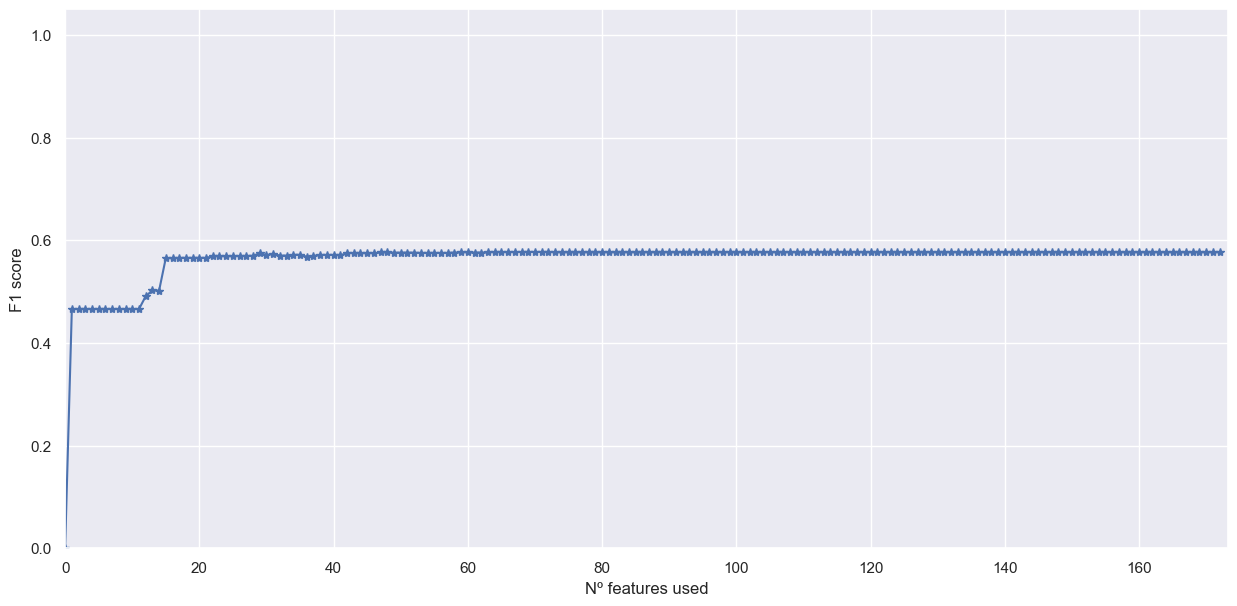

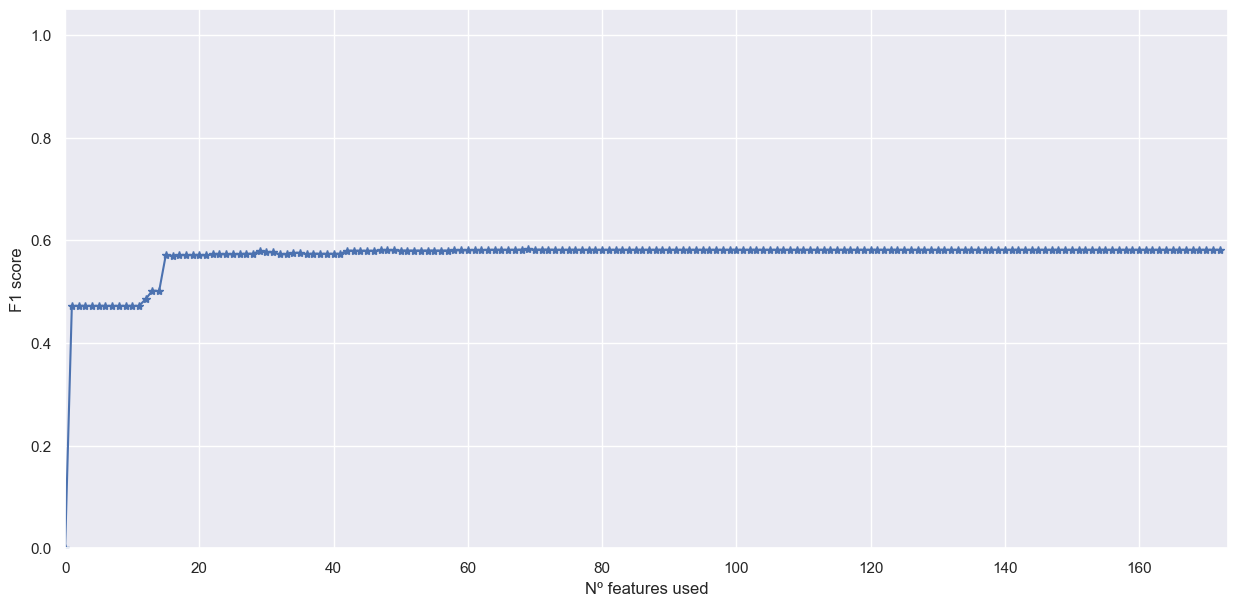

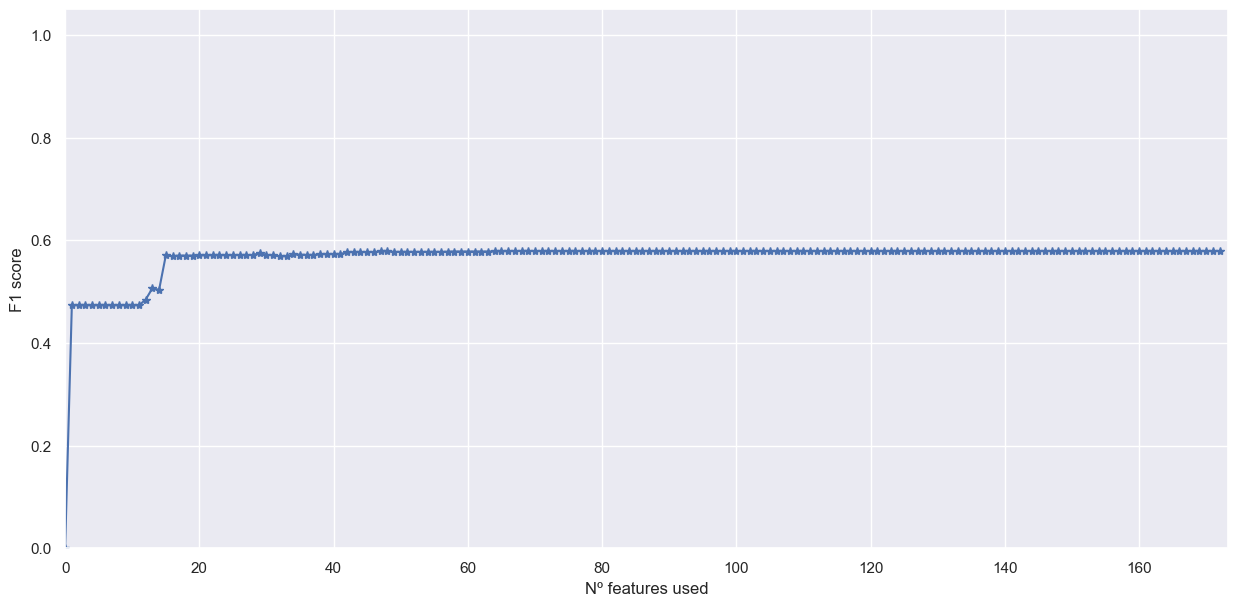

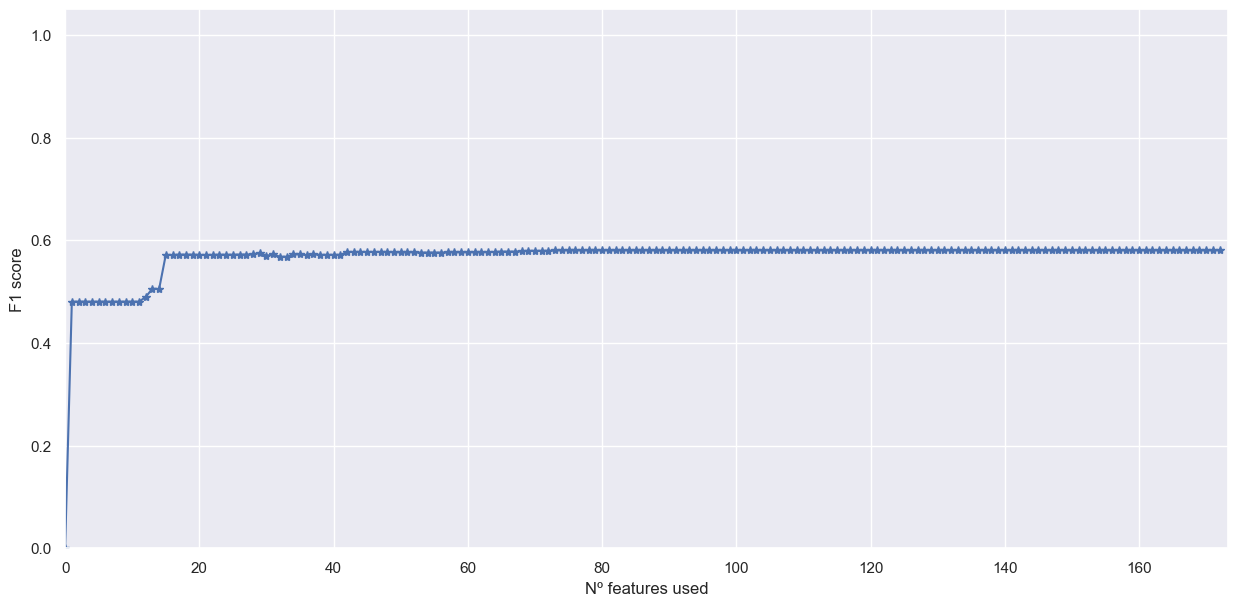

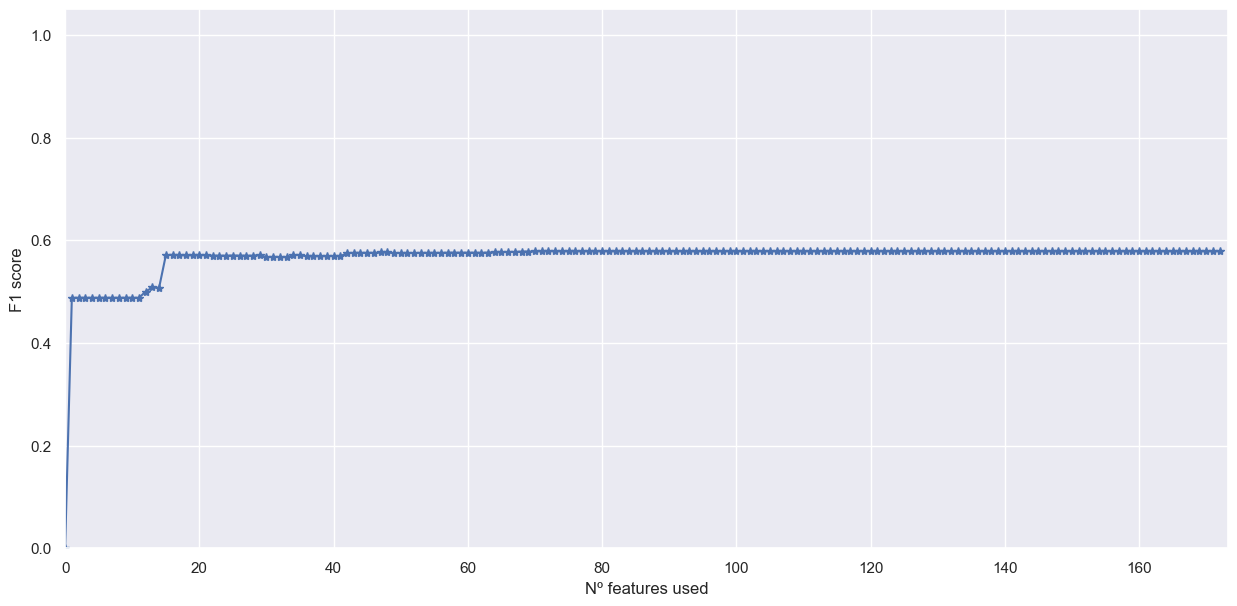

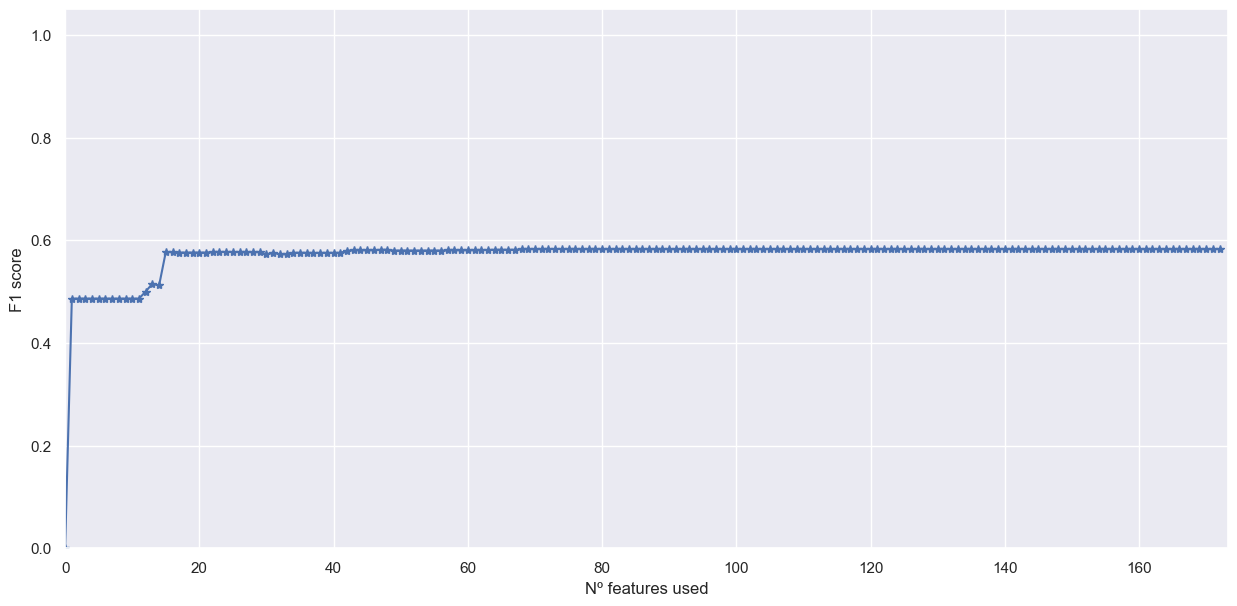

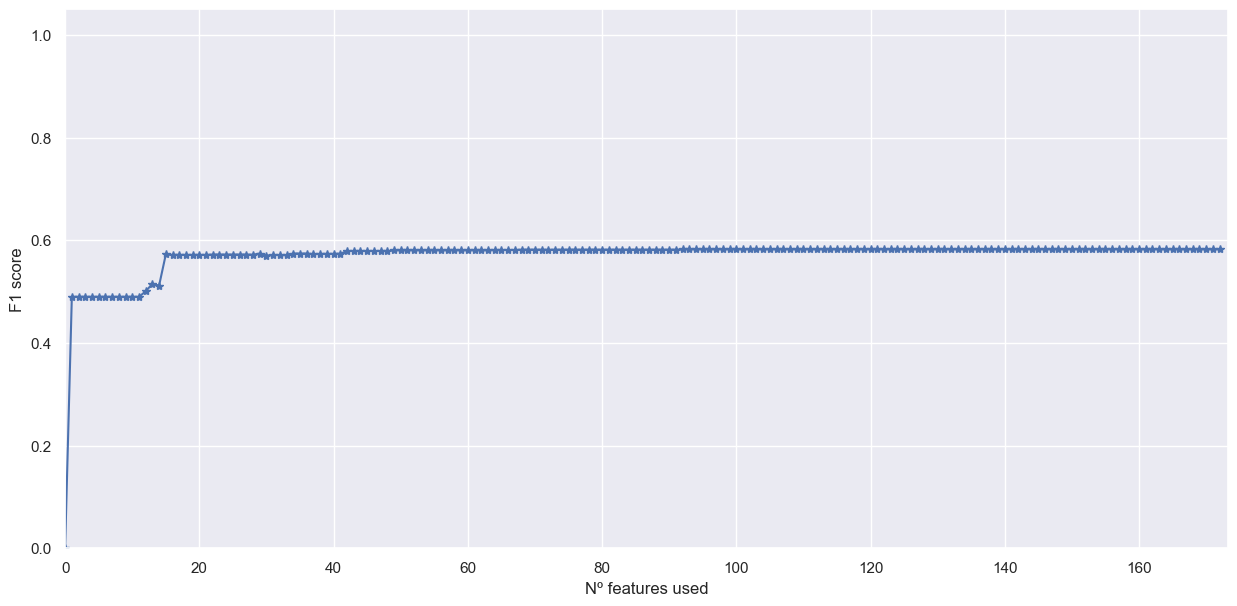

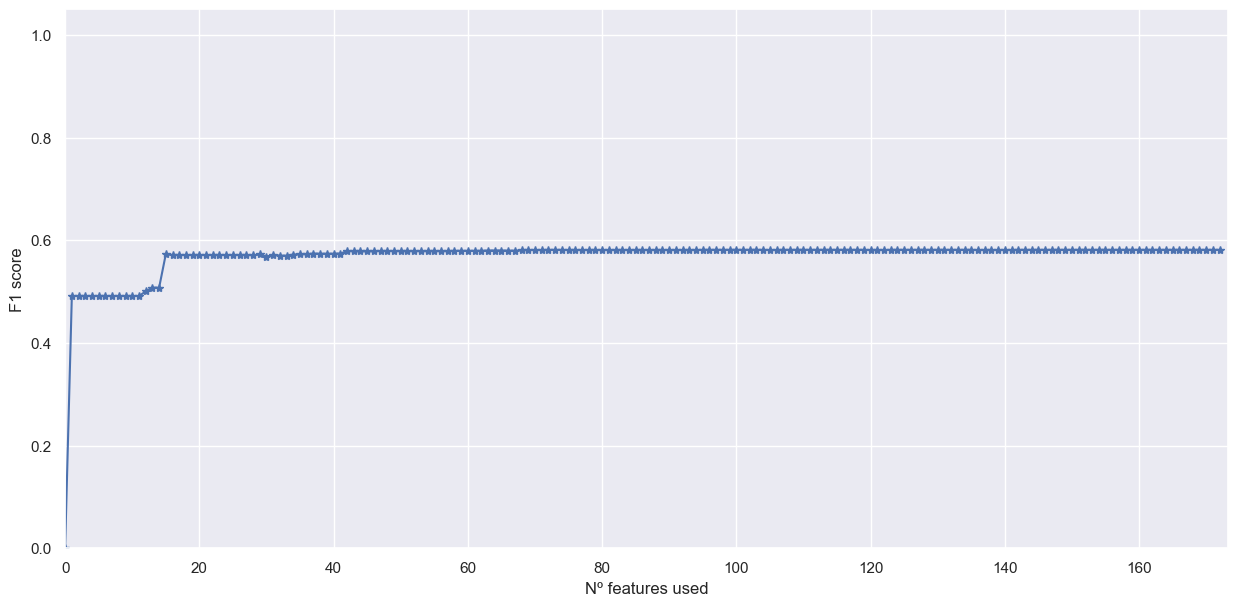

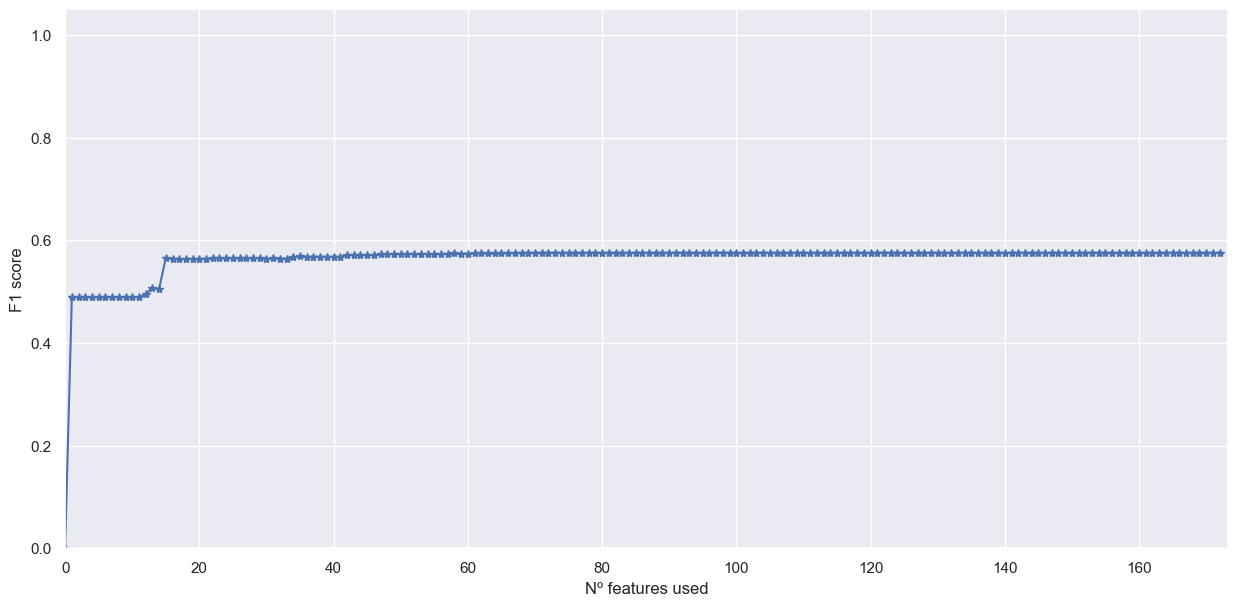

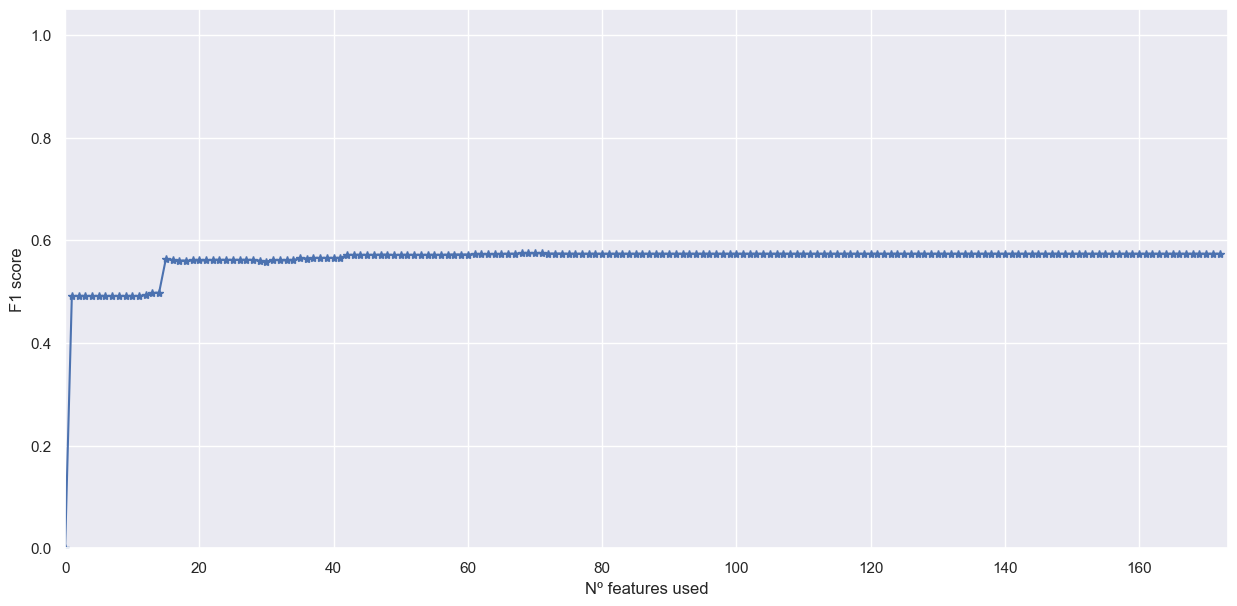

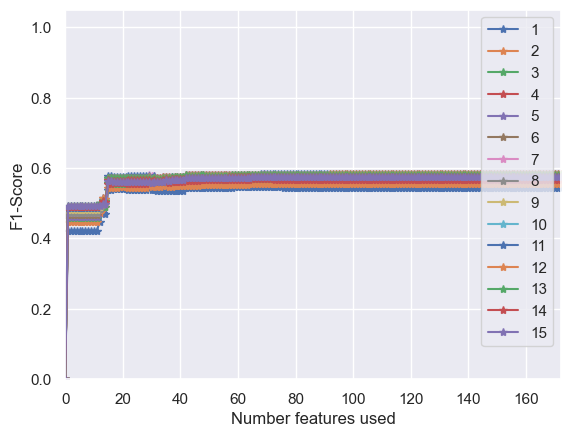

Max f1-score:  0.5828600676167468
Model used:  12
Best number features: 73
CPU times: total: 32min 59s
Wall time: 11min 2s


In [191]:
%%time
results, best_k, best_n_features = best_model_feature_and_k(x_train, x_val, y_train, y_val, relieff_features, plot=True)

In [192]:
results

,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15,K16
1,0.422064,0.446021,0.458601,0.468011,0.459659,0.465821,0.472012,0.473146,0.480332,0.487829,0.486235,0.489786,0.491309,0.488822,0.491338
2,0.422064,0.446021,0.458601,0.468011,0.459659,0.465821,0.472012,0.473146,0.480332,0.487829,0.486235,0.489786,0.491309,0.488822,0.491338
3,0.422064,0.446021,0.458601,0.468011,0.459659,0.465821,0.472012,0.473146,0.480332,0.487829,0.486235,0.489786,0.491309,0.488822,0.491338
4,0.422064,0.446021,0.458601,0.468011,0.459659,0.465821,0.472012,0.473146,0.480332,0.487829,0.486235,0.489786,0.491309,0.488822,0.491338
5,0.422064,0.446021,0.458601,0.468011,0.459659,0.465821,0.472012,0.473146,0.480332,0.487829,0.486235,0.489786,0.491309,0.488822,0.491338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.544158,0.553555,0.568611,0.566886,0.574710,0.576327,0.581314,0.578742,0.580098,0.578253,0.582482,0.581995,0.581151,0.575673,0.573678
169,0.544158,0.553555,0.568611,0.566886,0.574710,0.576327,0.581314,0.578742,0.580098,0.578253,0.582482,0.581995,0.581151,0.575673,0.573678
170,0.544158,0.553555,0.568611,0.566886,0.574710,0.576327,0.581314,0.578742,0.580098,0.578253,0.582482,0.581995,0.581151,0.575673,0.573678
171,0.544158,0.553555,0.568611,0.566886,0.574710,0.576327,0.581314,0.578742,0.580098,0.578253,0.582482,0.581995,0.581151,0.575673,0.573678


#### retrain best model

In [49]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [50]:
features_to_use = relieff_features[:best_n_features]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 0.599087105363256
Precision: 0.5598269819454456
F-Score: 0.576534570909447


c:\Users\joana\anaconda3\envs\cl_human_activities\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

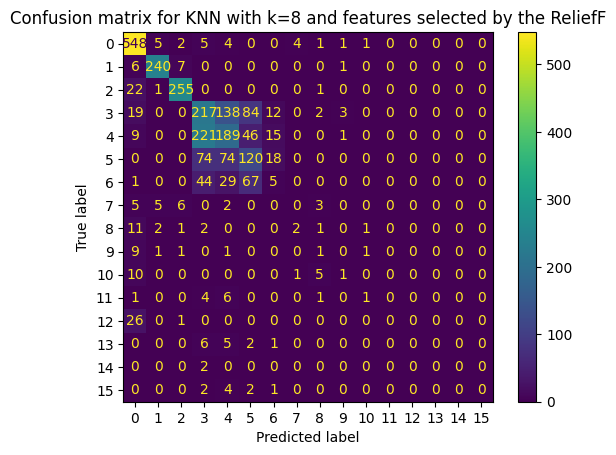

array([[548,   5,   2,   5,   4,   0,   0,   4,   1,   1,   1,   0,   0,
          0,   0,   0],
       [  6, 240,   7,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [ 22,   1, 255,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0],
       [ 19,   0,   0, 217, 138,  84,  12,   0,   2,   3,   0,   0,   0,
          0,   0,   0],
       [  9,   0,   0, 221, 189,  46,  15,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,  74,  74, 120,  18,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   0,  44,  29,  67,   5,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  5,   5,   6,   0,   2,   0,   0,   0,   3,   0,   0,   0,   0,
          0,   0,   0],
       [ 11,   2,   1,   2,   0,   0,   0,   2,   1,   0,   1,   0,   0,
          0,   0,   0],
       [  9,   1,   1,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0,
          0,   0,   0],
       [ 10,   0,   0,   0,   

In [51]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features selected by the ReliefF')

## Ex.4 - Neural Network

In [52]:
from sklearn.neural_network import MLPClassifier

In [53]:
%%time
#relieff_features = order_features(x_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
def best_model(x_train, x_val, y_train, y_val, features, function='ReliefF', plot=False):
    max_score = 0
    best_k = 0
    for units in range(10, 3*len(features),10):
        model = MLPClassifier(hidden_layer_sizes=(units,), activation='logistic', learning_rate='constant', max_iter=500)
        model.fit(x_train[features], y_train)
        y_pred = model.predict(x_val[features])
        f1 = calculate_f1(y_val, y_pred,  'weighted')
        if f1 > max_score:
            max_score = f1
            best_k = units
    print('Max f1-score: ', max_score)
    print('Best no. of neurons: ', best_k,)
    return  best_k

In [55]:
%%time
best_model(x_train, x_val, y_train, y_val, relieff_features[:best_n_features])

Max f1-score:  0.3421035354944654
Model used:  90
CPU times: total: 27.2 s
Wall time: 1min 23s


90

In [ ]:
## retreinar o melhor modelo com os dado reais
## plot com os dados

## Ex. 5 - NN from scratch

In [421]:
class Layer():
    def __init__(self, input_size, output_size):
        self.input = None
        self.output = None
        self.weights = np.random.rand(output_size, input_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def forward_prop(self, input_data):
        # print('>> forward_prop')
        # print(input_data)
        # print(input_data.shape)
        # print(self.weights.shape)
        # print('---')
        self.input = input_data
        self.output = np.dot(self.input, self.weights.T) + self.bias
        return self.output

    def backward_prop(self, output_error, learning_rate):
        # print('>> backward_prop')
        # print(output_error)
        # print(output_error.shape)
        # print(self.weights.shape)
        # print('---')
        input_error = np.dot(output_error, self.weights)
        weights_error = np.dot(self.input.reshape(-1,1), output_error)
        # print(weights_error.shape)
        # print(weights_error)
        # print(learning_rate)

        # update
        self.weights -= learning_rate * weights_error.T
        self.bias -= learning_rate * output_error

        return input_error

In [422]:
class Activation:
    def __init__(self):
        pass

    def forward_prop(self, input):
        self.input = input
        self.output = self.activation(self.input)
        # print('>>activation')
        # print(self.output)
        return self.output

    def backward_prop(self, output_error, learning_rate):
        return self.activation_inverse(self.input) * output_error

    def activation(self, data):
        # return scipy.special.expit(data)
        return np.tanh(data);


    def activation_inverse(self, data):
        # return scipy.special.logit(data)
        return 1-np.tanh(data)**2;


In [423]:
class NeuralNetwork():
    def __init__(self, layers_units, epochs, learning_rate):
        self.layers_units = layers_units
        self.layers = []
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.create_layers()

    def create_layers(self):
        for i in range(0, len(self.layers_units)-1):
            self.layers.append(Layer(self.layers_units[i], self.layers_units[i+1]))
            self.layers.append(Activation())

    def mse(self, real, pred):
        return np.mean(np.power(real-pred, 2))

    def mse_inverse(self, real, pred):
        return 2*(pred-real)/real.size

    def fit(self, X, y):
        input_size = X.shape[0]
        for epoch in range(self.epochs):
            loss = 0
            for sample in range(input_size):
                # forward propagation
                output = X[sample]
                for layer in self.layers:
                    output = layer.forward_prop(output)

                # calculate loss
                mse = self.mse(y[sample], output)
                # print('MSE: ', mse)
                loss += mse

                # calculate error
                error = self.mse_inverse(y[sample], output)
                # print('Error:', error)

                # backward propagation
                for layer in reversed(self.layers):
                    error = layer.backward_prop(error, self.learning_rate)


            # print(f'Epoch {epoch} - error={loss/input_size}')

    def predict(self, input):
        input_size = input.shape[0]
        predictions = []

        for sample in range(input_size):
            output = input[sample]
            for layer in self.layers:
                output = layer.forward_prop(output)
            predictions.append(np.argmax(output))
            # predictions.append(output)

        return np.array(predictions)

### Test on the Iris Dataset

In [424]:
X, y,_  = load_dataset()

In [496]:
x_train, x_test, y_train, y_test = split_train_test(X, y)

In [497]:
y_test = y_test.reset_index(drop=True)

In [466]:
model = NeuralNetwork([x_train.shape[1], 4, len(y_train.unique())], 1500, 0.05)

In [467]:
model.fit(x_train.to_numpy(), y_train.to_numpy())

In [468]:
y_pred = model.predict(x_test.to_numpy())

In [469]:
y_pred = pd.Series(y_pred)

In [499]:
y_test.value_counts()

0    19
1    13
2    13
Name: target, dtype: int64

<Figure size 640x480 with 0 Axes>

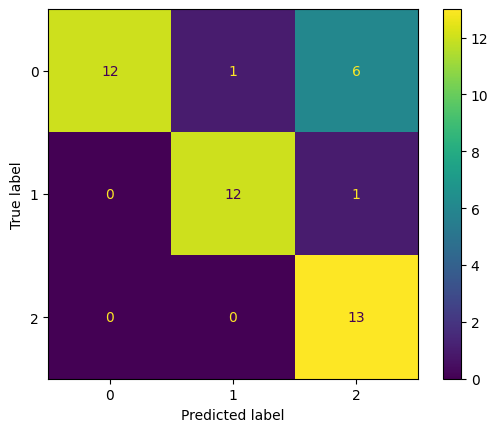

array([[12,  1,  6],
       [ 0, 12,  1],
       [ 0,  0, 13]], dtype=int64)

In [471]:
calculate_confusion_matrix(y_test, y_pred)

In [503]:
df = pd.DataFrame()
df['original'] = y_test
df['pred'] = y_pred
df

,original,pred
0,1,1
1,0,2
2,2,2
3,1,1
4,1,1
5,0,0
6,1,1
7,2,2
8,1,2
9,1,1


In [504]:
(y_test == y_pred).sum()

37

### Test on the Human Activities Dataset

In [ ]:
features_path = os.path.join('results', 'extracted_features.csv')

In [ ]:
X = pd.read_csv(features_path)
y = X.pop('activity')

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [ ]:
relieff_features = order_features(x_train, y_train)

In [ ]:
results, best_k, best_n_features = best_model_feature_and_k(x_train, x_val, y_train, y_val, relieff_features, plot=False)

In [ ]:
features_to_use = relieff_features[:best_n_features]